# Field Retrieval: Reconstructing Complex Fields from Intensity Measurements

This tutorial demonstrates phase retrieval using gradient-based optimization.
From intensity-only measurements in two planes, we reconstruct the full complex
field (amplitude and phase) using automatic differentiation.

## The Phase Problem

Standard detectors measure only intensity |u|², losing phase information. However,
with measurements at multiple propagation distances, the complex field can be
recovered through optimization - a generalization of the Gerchberg-Saxton algorithm
using gradients rather than alternating projections.

In [1]:
using FluxOptics, Zygote, CairoMakie
using CUDA  # Comment if you don't have CUDA
using Random
Random.seed!(15);  # Determinist example

## Ground Truth: Laguerre-Gaussian Mode

We create a high-order LG mode as our target field. This will serve as the
ground truth - we'll measure its intensity at two planes, then attempt to
reconstruct the complex field from these measurements alone.

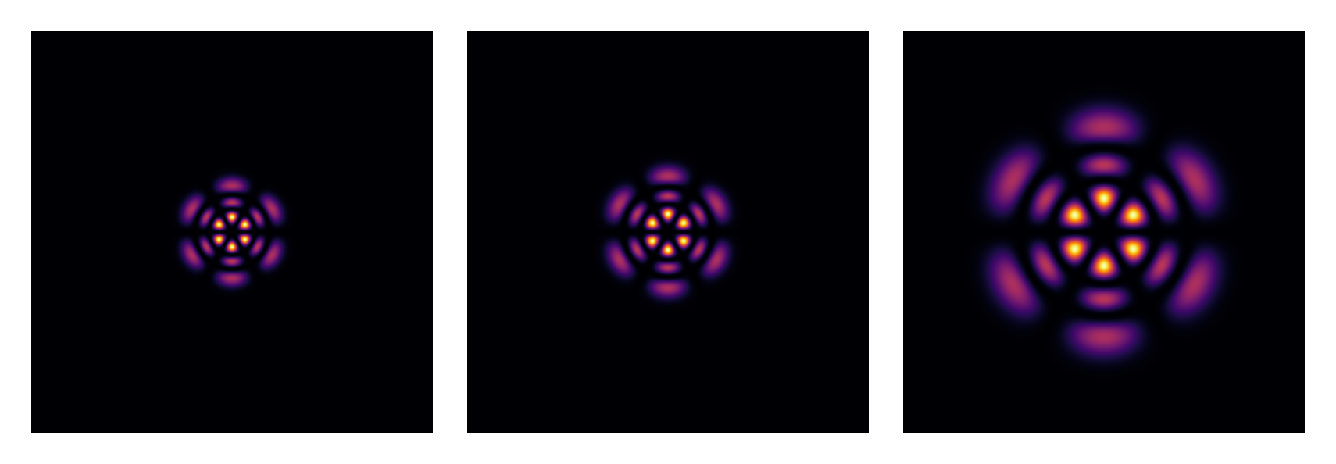

In [2]:
ns = 512, 512
ds = 2.0, 2.0
x_vec, y_vec = spatial_vectors(ns, ds)

λ = 1.064
z1 = 5000.0
z2 = 15000.0

w0 = 50.0
m, n = 2, 3

u0_th = LaguerreGaussian(w0, m, n; kind = :odd)(x_vec, y_vec)
u1_th = LaguerreGaussian(w0, m, n, λ, z1; kind = :odd)(x_vec, y_vec)
u2_th = LaguerreGaussian(w0, m, n, λ, z2; kind = :odd)(x_vec, y_vec)

visualize(((u0_th, u1_th, u2_th),), intensity; colormap=:inferno, height=200)

## Intensity Measurements

In a real experiment, we would measure only the intensity at two planes.
Here we simulate these measurements from our known ground truth.

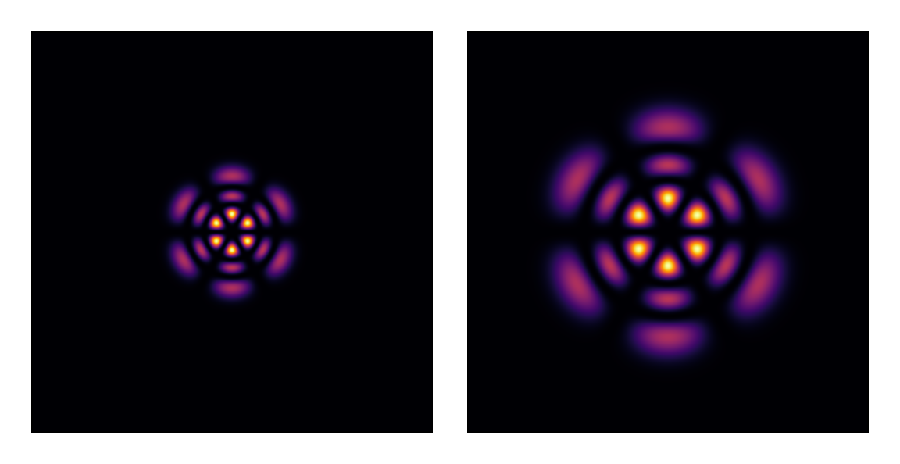

In [3]:
I1 = abs.(u1_th) .^ 2
I2 = abs.(u2_th) .^ 2

@assert isapprox(sum(I1)*prod(ds), 1; atol = 1e-7)  # Power normalized to unity
@assert isapprox(sum(I2)*prod(ds), 1; atol = 1e-7)  # Power normalized to unity

I1 = cu(I1)  # Comment if you don't have CUDA
I2 = cu(I2)  # Comment if you don't have CUDA

visualize(((I1, I2),), real; colormap=:inferno, height=200)

## Initial Guess: Random Speckle

We start from a random speckle pattern - a generic field with no knowledge
of the target mode. The optimization will transform this into the LG mode.

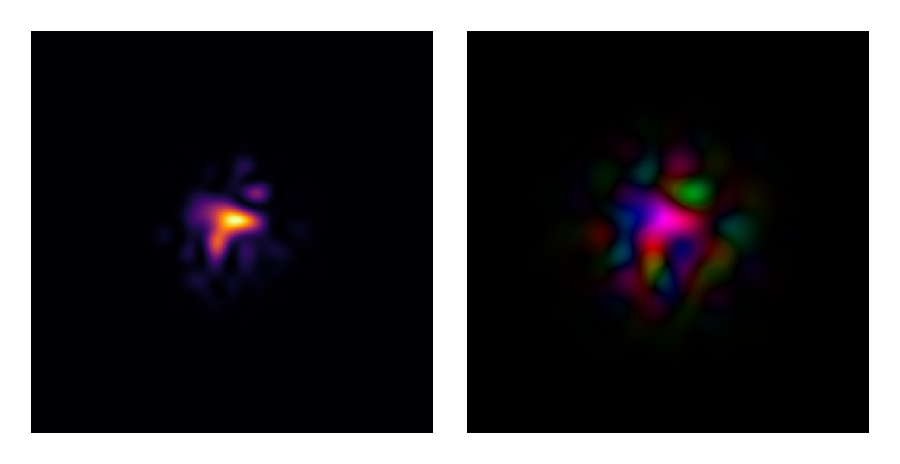

In [4]:
NA = 0.01
speckle_dist = generate_speckle(ns, ds, λ, NA; envelope = Gaussian(3*w0))
u0 = ScalarField(speckle_dist, ds, λ)
u0 = cu(u0)  # Comment if you don't have CUDA

visualize(u0, (intensity, complex); colormap=(:inferno, :dark), height=200)

## Optical System Setup

We construct the propagation system with probes to capture fields at measurement
planes. The source field is trainable - its complex values will be optimized.

In [5]:
p1 = RSProp(u0, z1; use_cache = true)
p2 = RSProp(u0, z2-z1; use_cache = true)

s = ScalarSource(u0; trainable = true, buffered = true)
fp1 = FieldProbe()
fp2 = FieldProbe()

model = s |> p1 |> fp1 |> p2 |> fp2 |> (; inplace = true);

## Loss Function

We minimize the difference between predicted and measured intensities using
a correlation-based metric. The loss is defined as 2 - (correlation₁ + correlation₂),
where perfect reconstruction gives loss = 0.

In [6]:
sI1 = sqrt.(I1)
sI2 = sqrt.(I2)
eps = 1e-15 * maximum(I1)

function f_opt(m)
    _, probes = m()
    u1 = probes[fp1]
    u2 = probes[fp2]
    (2 -
     (dot(sqrt.(abs2.(u1.electric) .+ eps), sI1) +
      dot(sqrt.(abs2.(u2.electric) .+ eps), sI2)) * prod(ds))
end

f_opt (generic function with 1 method)

## Optimization

We use FISTA (Fast Iterative Shrinkage-Thresholding Algorithm) with gradient-based
optimization. The non-convex nature of phase retrieval means convergence can take
many iterations, with the optimizer navigating through local minima. Power
normalization at each step prevents divergence.

In [7]:
opt = setup(Fista(1), model)
_, g = Zygote.withgradient(f_opt, model);  # Warm-up
FluxOptics.update!(opt, model, g[1]);  # Warm-up

fill!(s, u0)
losses = []

@time for i in 1:1000
    val, grads = Zygote.withgradient(f_opt, model)
    FluxOptics.update!(opt, model, grads[1])
    normalize_power!(get_source(s), 1)  # Power normalization to avoid divergence
    push!(losses, val)
end

  1.844212 seconds (5.96 M allocations: 257.947 MiB, 4.99% gc time, 1 lock conflict)


The convergence curve reveals the non-convex nature of the phase retrieval problem,
with several plateaus before reaching the global minimum.

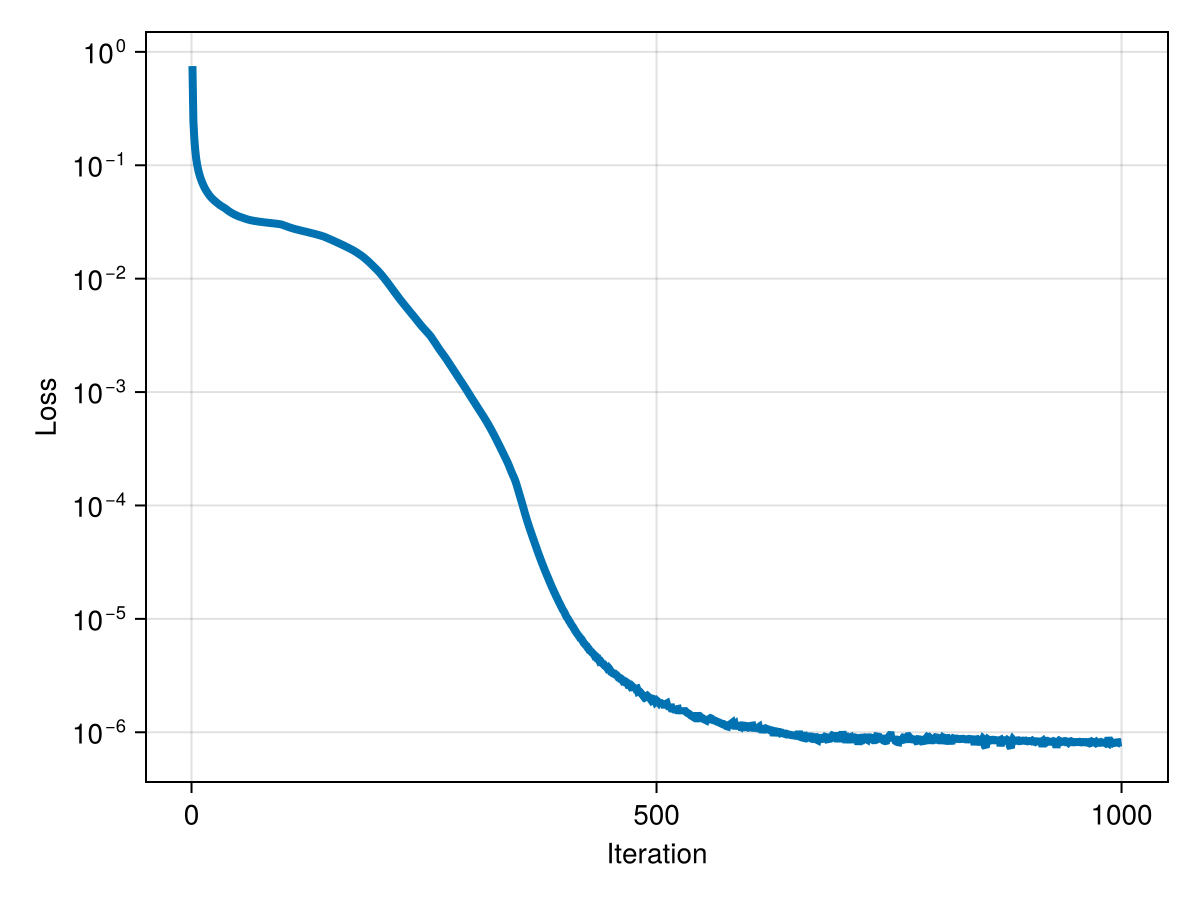

In [8]:
fig_loss = Figure()
ax = Makie.Axis(fig_loss[1, 1], yscale = log10, xlabel = "Iteration", ylabel = "Loss")
lines!(ax, losses; linewidth = 4)
fig_loss

## Reconstructed Field

After optimization, we extract the reconstructed field and propagated versions
at the measurement planes. The complex field structure (intensity and phase)
is successfully recovered from intensity-only measurements.

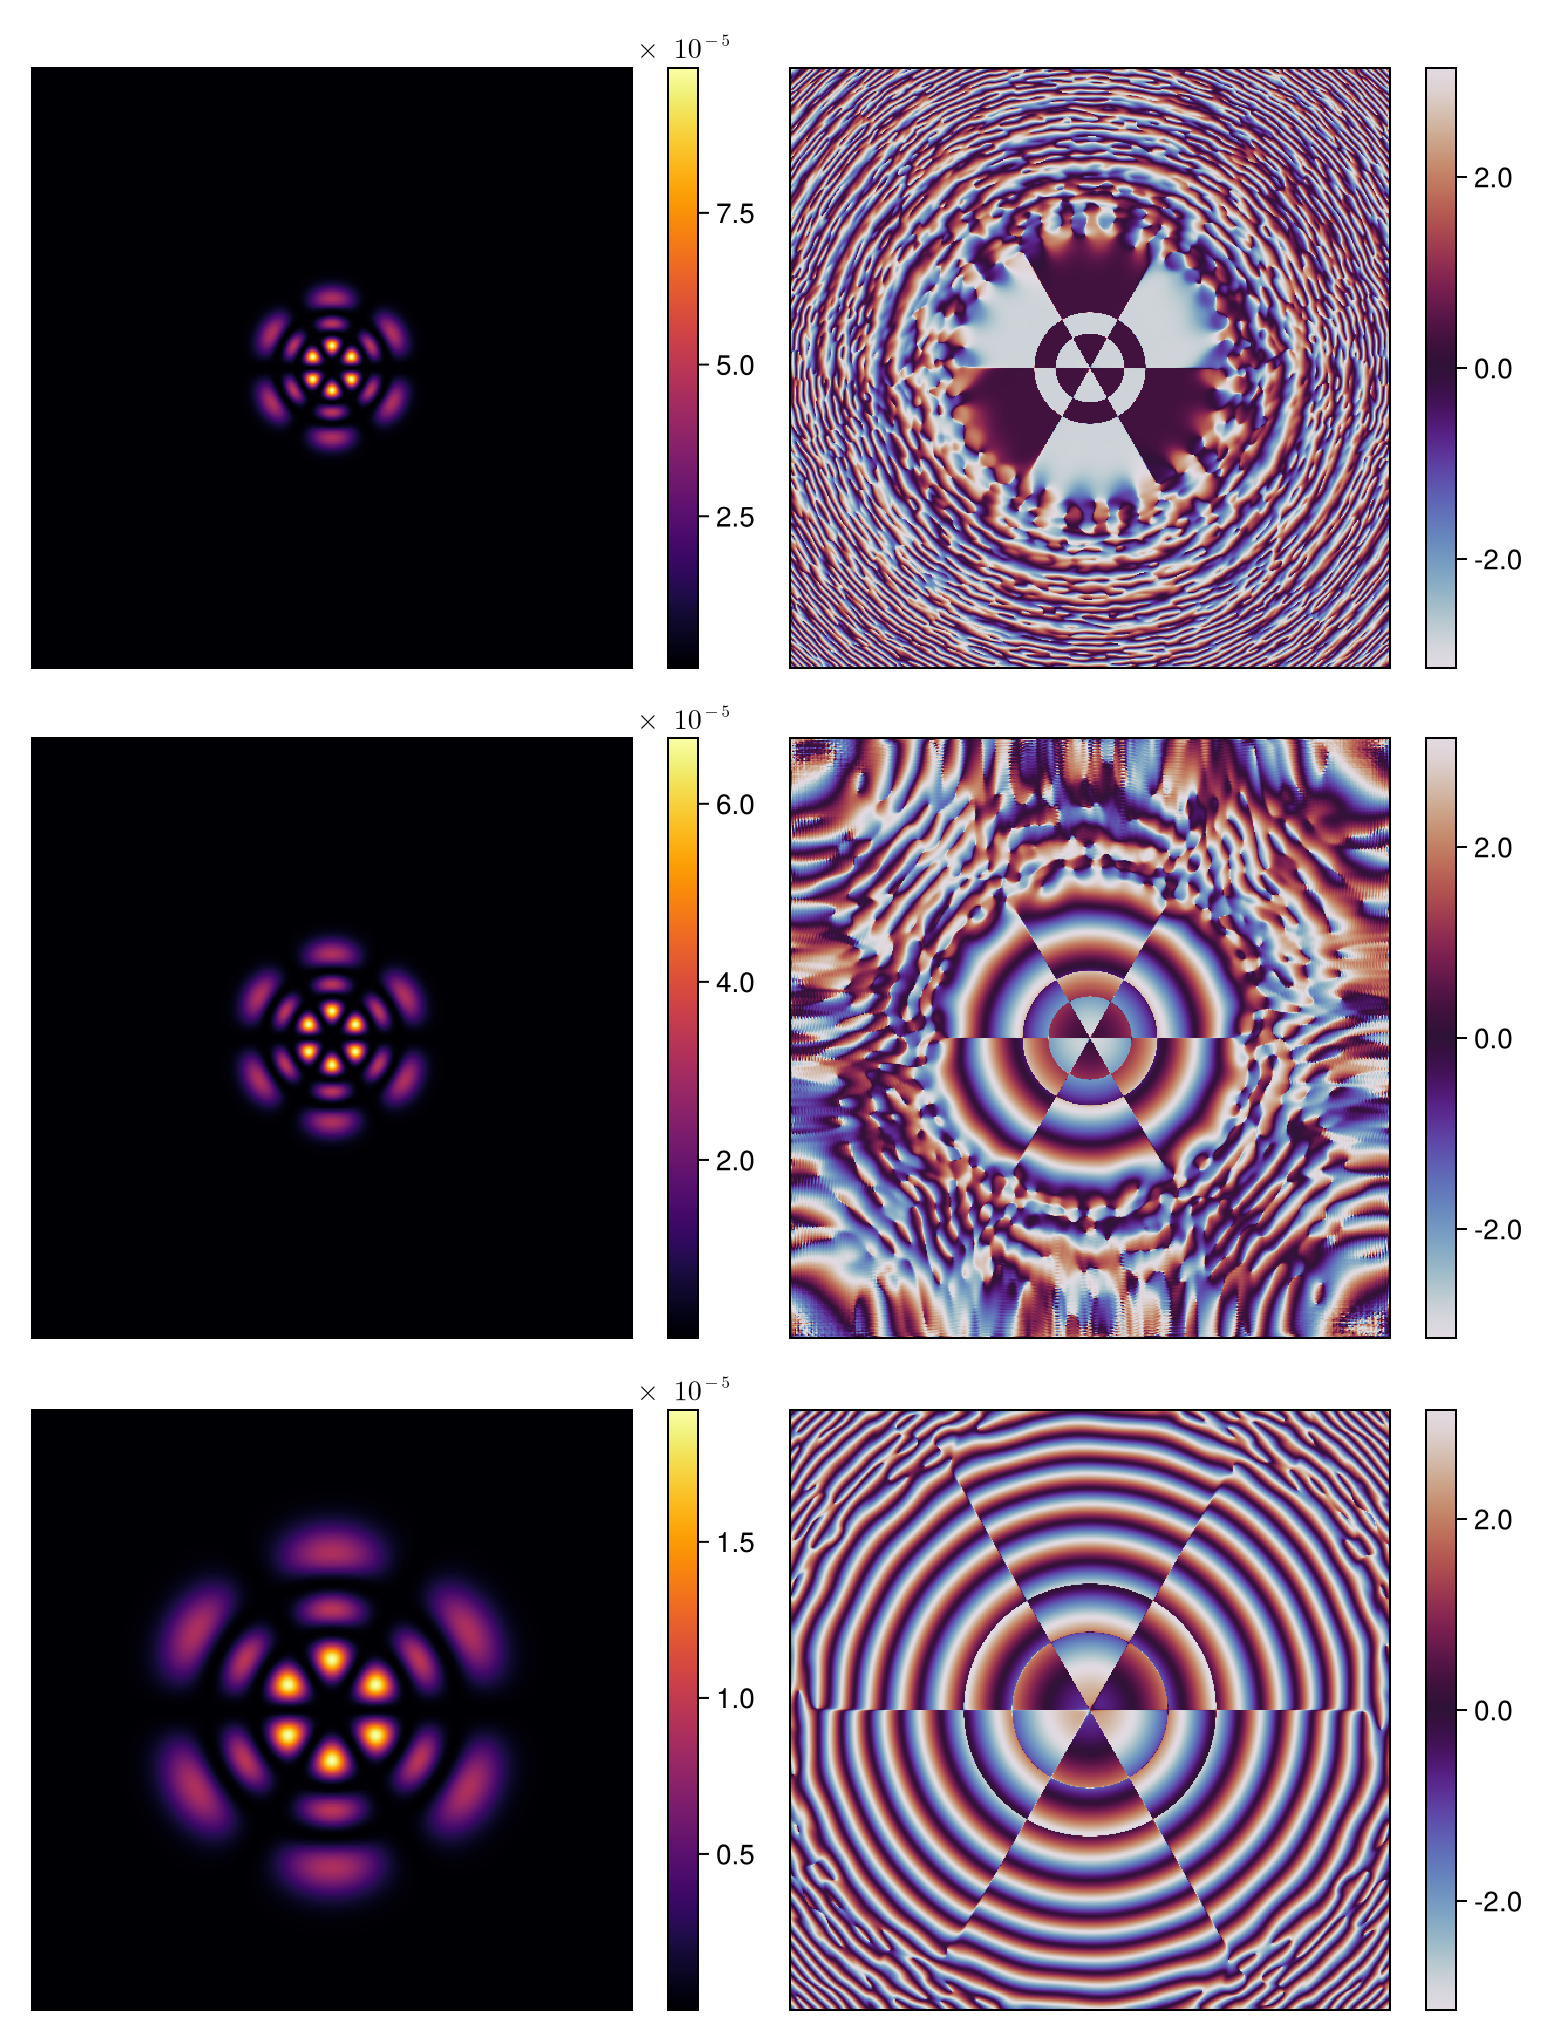

In [9]:
_, probes = model()
u1 = probes[fp1]
u2 = probes[fp2]

visualize((s, u1, u2), (intensity, phase); colormap=(:inferno, :twilight), show_colorbars=true, height=300)

## Reconstruction Quality

We quantify reconstruction quality using coupling efficiency - the overlap
integral between reconstructed and true fields. Values above 99% indicate
excellent reconstruction.

In [10]:
coupling_effs = [coupling_efficiency(u, v) for (u, v) in
                 zip(collect.((s, u1, u2)), (u0_th, u1_th, u2_th))]

3-element Vector{Float64}:
 0.9999530380454205
 0.9999530724035302
 0.9999531645963803

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*